Імпортував бібліотеки. Провів базовий аналіз та перевірку даних:
Записи без пропусків. Більшість колонок — категорії, числових мало.
Billing Amount має підозріле від’ємне значення і широку варіацію

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

df = pd.read_csv('data/healthcare_dataset.csv')

In [111]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


По коментарях все зрозуміло. 

In [112]:
# Фільтрація для бінарної класифікації: ігноруємо "Inconclusive"
df = df[df['Test Results'] != 'Inconclusive']

# Видалення непотрібних колонок
cols_drop = [
    'Name','Date of Admission','Doctor',
    'Hospital','Room Number','Discharge Date', 'Insurance Provider'
]
df = df.drop(columns=cols_drop)

# Створення цілі (1 = Normal)
df['Test_Result_Normal'] = (df['Test Results'] == 'Normal').astype(int)

# Видаляємо оригінальну текстову колонку щоб вона не потрапила у X
df = df.drop(columns=['Test Results'])

# One-hot кодування категорій
cat_cols = ['Gender','Blood Type','Medical Condition','Admission Type','Medication']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

numerical_cols = ['Age','Billing Amount']

# Формуємо X та y
X = df.drop(columns=['Test_Result_Normal'])
y = df['Test_Result_Normal']

# Train/Val/Test спліт
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Масштабування лише числових ознак
scaler = StandardScaler()
X_train.loc[:, numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val.loc[:, numerical_cols]   = scaler.transform(X_val[numerical_cols])
X_test.loc[:, numerical_cols]  = scaler.transform(X_test[numerical_cols])

/tmp/ipykernel_389518/2307747075.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.79095075  0.53165489 -1.14703689 ... -0.12964793 -0.8418202
  1.09121882]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
/tmp/ipykernel_389518/2307747075.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.2264382  -1.50312302 -1.09616744 ... -0.28225627 -0.53660351
  1.14208827]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_val.loc[:, numerical_cols]   = scaler.transform(X_val[numerical_cols])
/tmp/ipykernel_389518/2307747075.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.2264382   1.44730495 -0.38399517 

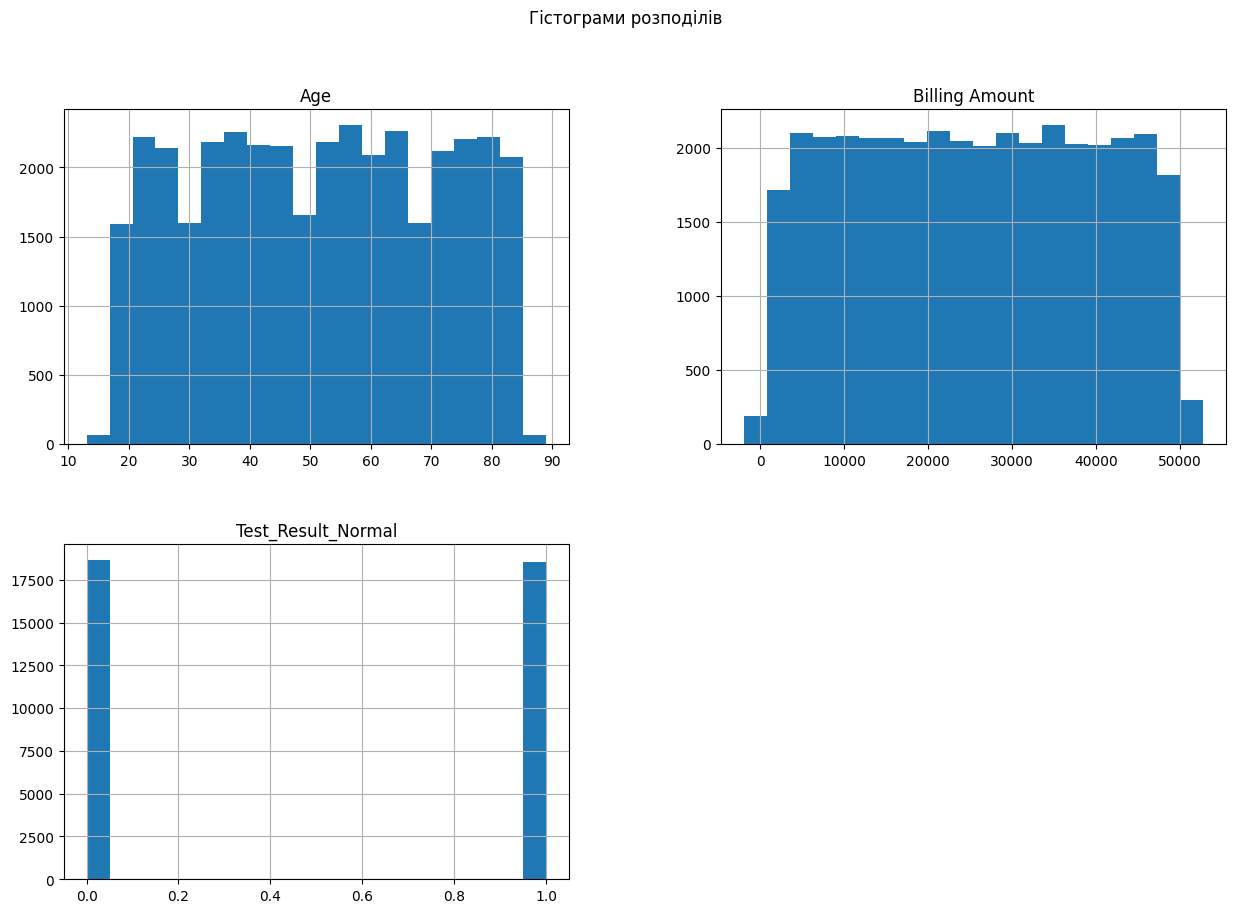

Test_Result_Normal
0    0.501481
1    0.498519
Name: proportion, dtype: float64

In [113]:
# --- Histograms and class balance ---
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Гістограми розподілів')
plt.show()
df['Test_Result_Normal'].value_counts(normalize=True)

Через нечитабельність графіку кореляцій - вивів в консоль.

                                     Age  Billing Amount  Test_Result_Normal  \
Age                             1.000000       -0.009383           -0.007911   
Billing Amount                 -0.009383        1.000000           -0.002871   
Test_Result_Normal             -0.007911       -0.002871            1.000000   
Gender_Male                    -0.000413        0.000870            0.005987   
Blood Type_A-                   0.003646        0.001126            0.001042   
Blood Type_AB+                  0.000884        0.002981            0.001606   
Blood Type_AB-                 -0.003060        0.008799            0.003476   
Blood Type_B+                   0.005368       -0.006704           -0.001101   
Blood Type_B-                  -0.009932       -0.000732           -0.000499   
Blood Type_O+                  -0.001825       -0.015282           -0.002050   
Blood Type_O-                   0.001179        0.006989           -0.000352   
Medical Condition_Asthma        0.001874

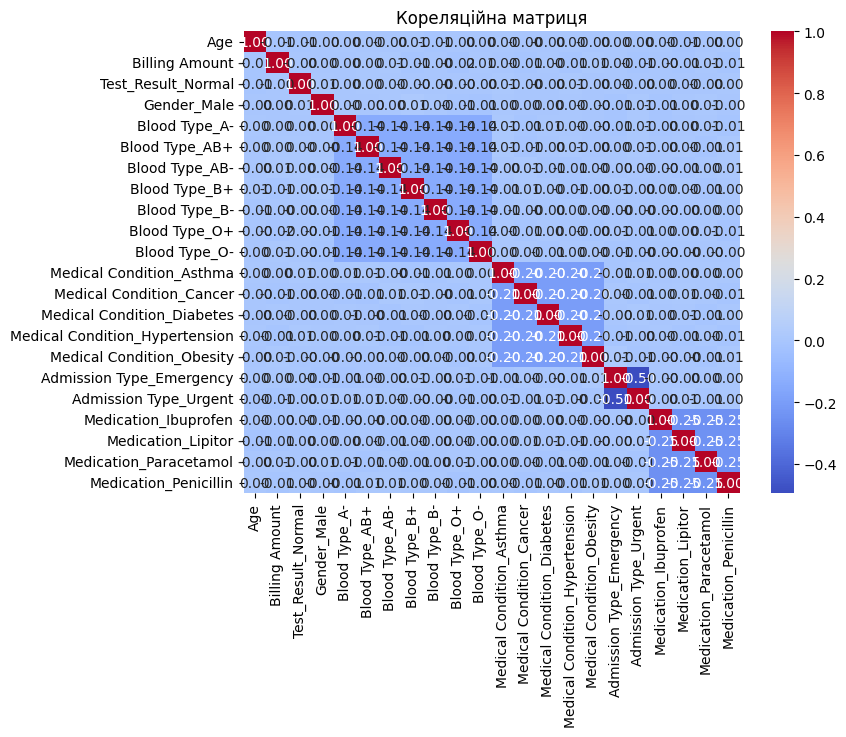

In [114]:
# --- Correlation analysis ---
numerical_df = df.select_dtypes(include=[np.number])

correlation_matrix = df.corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Кореляційна матриця')
plt.show()

Важливий крок — додати колонку на зсув (bias): вставляємо стовпець з 1, щоб перший параметр  w_0 був інтерсептом і модель могла зміщувати межу рішень. Потім рахуємо кількість ознак і задаємо базові гіперпараметри для тренування з ранньою зупинкою.


In [115]:
# intercept (bias)
X_train = np.c_[np.ones(X_train.shape[0]), X_train.values]
X_val = np.c_[np.ones(X_val.shape[0]), X_val.values]
X_test = np.c_[np.ones(X_test.shape[0]), X_test.values]

# приведення типів
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

n_features = X_train.shape[1]
print(f"Кількість ознак: {n_features}")


Кількість ознак: 22


In [116]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))


def compute_loss(X, y, w, reg_type=None, lambda_reg=0.0, class_weights=None, include_reg=True):
    """
    Binary cross-entropy (optionally weighted) with optional regularization.
    include_reg=False makes it compute only data loss (useful for validation curves).
    """
    m = X.shape[0]
    p = sigmoid(X @ w)
    p = np.clip(p, 1e-15, 1 - 1e-15)

    if class_weights is None:
        loss = - (1 / m) * np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    else:
        w0, w1 = class_weights[0], class_weights[1]
        sample_w = np.where(y == 1, w1, w0)
        norm = sample_w.sum()
        loss = - (1 / norm) * np.sum(sample_w * (y * np.log(p) + (1 - y) * np.log(1 - p)))

    if include_reg and lambda_reg > 0:
        if reg_type == 'l2':
            loss += (lambda_reg / (2 * m)) * np.sum(w[1:] ** 2)
        elif reg_type == 'l1':
            loss += (lambda_reg / m) * np.sum(np.abs(w[1:]))

    return loss


def compute_gradients(X, y, w, reg_type=None, lambda_reg=0.0, class_weights=None):
    m = X.shape[0]
    p = sigmoid(X @ w)
    if class_weights is None:
        errors = p - y
        denom = m
    else:
        w0, w1 = class_weights[0], class_weights[1]
        sample_w = np.where(y == 1, w1, w0)
        errors = (p - y) * sample_w
        denom = sample_w.sum()
    grad = (1 / denom) * X.T @ errors
    if reg_type == 'l2' and lambda_reg > 0:
        grad[1:] += (lambda_reg / m) * w[1:]
    elif reg_type == 'l1' and lambda_reg > 0:
        grad[1:] += (lambda_reg / m) * np.sign(w[1:])
    return grad


def get_batches(X, y, batch_size, shuffle=True):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, n, batch_size):
        j = idx[i:i + batch_size]
        yield X[j], y[j]

In [117]:
def train_model(X_train, y_train, X_val, y_val, learning_rate, max_epochs, 
                batch_size=32, method='mini-batch', patience=15, reg_type=None, 
                lambda_reg=0.0, class_weights=None, verbose=False):
    if method not in ('sgd', 'mini-batch'):
        raise ValueError("method must be 'sgd' or 'mini-batch'")
    w = np.random.normal(0, 0.01, X_train.shape[1])
    best_w = w.copy()
    best_val_loss = float('inf')
    no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        eff_bs = 1 if method == 'sgd' else batch_size
        for Xb, yb in get_batches(X_train, y_train, eff_bs, shuffle=True):
            grad = compute_gradients(Xb, yb, w, reg_type, lambda_reg, class_weights)
            w -= learning_rate * grad

        # Train loss can include reg (optimization objective)
        train_loss = compute_loss(X_train, y_train, w, reg_type, lambda_reg, class_weights, include_reg=True)
        # Validation loss should exclude reg to reflect generalization
        val_loss = compute_loss(X_val, y_val, w, reg_type, lambda_reg, class_weights, include_reg=False)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss - 1e-6:  # tiny tolerance to avoid flapping
            best_val_loss = val_loss
            best_w = w.copy()
            no_improve = 0
        else:
            no_improve += 1

        if verbose and epoch % 50 == 0:
            print(f"Epoch {epoch:4d} train={train_loss:.4f} val={val_loss:.4f}")

        if no_improve >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    if verbose:
        print(f"Best val_loss={best_val_loss:.4f}")

    return best_w, train_losses, val_losses

In [118]:
# обчислює ймовірності класу 1 для логістичної регресії як σ(Xw).
def predict_proba(X, w):
    """Повертає ймовірності класів за допомогою сигмоїди."""
    return sigmoid(X @ w)

# перетворює ймовірності у бінарні передбачення за заданим порогом.
def predict(X, w, threshold=0.5):
    """Повертає бінарні передбачення на основі порогу."""
    return (predict_proba(X, w) >= threshold).astype(int)

# підбирає “найкращий” поріг класифікації на валідації за метрикою F1 або balanced accuracy.
def best_threshold(w, X_val, y_val, metric='f1'):
    """Знаходить оптимальний поріг на основі метрики (F1 або balanced accuracy)."""
    from sklearn.metrics import precision_recall_curve, balanced_accuracy_score
    probs = predict_proba(X_val, w)
    precisions, recalls, thresholds = precision_recall_curve(y_val, probs)
    f1s = 2 * precisions * recalls / (precisions + recalls + 1e-15)
    if metric == 'f1':
        best_idx = np.argmax(f1s)
        return thresholds[best_idx] if best_idx < len(thresholds) else 0.5, f1s[best_idx]
    elif metric == 'balanced_acc':
        balanced_accs = [balanced_accuracy_score(y_val, (probs >= t).astype(int)) for t in thresholds]
        best_idx = np.argmax(balanced_accs)
        return thresholds[best_idx] if best_idx < len(thresholds) else 0.5, balanced_accs[best_idx]
    return 0.5, None

In [119]:
# Гіперпараметри
learning_rate = 0.05 # крок оновлення ваг на кожній ітерації
lambda_reg = 0.001 # коефіцієнт регуляризації. Чим більший - тим сильніша регуляризація.
max_epochs = 3000
batch_size = 30 # для mini-batch
patience = 50 # кількість епох без покращення на валідації для ранньої зупинки

# Обчислення ваг класів
classes = np.array([0, 1])
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_w = dict(zip(classes, weights))
print("Ваги класів:", class_w)

# Навчання моделі SGD
weights_sgd, tr_sgd, vl_sgd = train_model(
    X_train, y_train, X_val, y_val,
    learning_rate=learning_rate,
    max_epochs=max_epochs,
    batch_size=1,  # Для SGD batch_size завжди 1
    method='sgd',
    patience=patience,
    reg_type='l1',
    lambda_reg=lambda_reg,
    class_weights=class_w,
    verbose=True
)

#  Mini-batch
weights_mb, tr_mb, vl_mb = train_model(
    X_train, y_train, X_val, y_val,
    learning_rate=learning_rate,
    max_epochs=max_epochs,
    batch_size=batch_size,  
    method='mini-batch',
    patience=patience,
    reg_type='l2',  
    lambda_reg=lambda_reg,
    class_weights=class_w,
    verbose=True
)

Ваги класів: {np.int64(0): np.float64(0.9970472440944882), np.int64(1): np.float64(1.002970297029703)}
Epoch    0 train=0.7065 val=0.7073
Epoch   50 train=0.7533 val=0.7537
Epoch  100 train=0.7151 val=0.7169
Epoch  150 train=0.7149 val=0.7136
Epoch  200 train=0.7142 val=0.7153
Early stopping at epoch 237
Best val_loss=0.6963
Epoch    0 train=0.6932 val=0.6934
Epoch   50 train=0.6929 val=0.6932
Early stopping at epoch 57
Best val_loss=0.6931


In [120]:
def evaluate(weights, X_val, y_val, X_test, y_test, name):
    """Оцінка моделі з оптимальним порогом на валідаційному наборі."""
    thr, _ = best_threshold(weights, X_val, y_val)  # Оптимальний поріг на основі F1
    y_pred = predict(X_test, weights, threshold=thr)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Best threshold: {thr:.3e}")
    print(f"Test metrics -> ACC: {acc:.4f}  PREC: {prec:.4f}  REC: {rec:.4f}  F1: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return {
        "name": name,
        "threshold": thr,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1
    }

# Оцінка моделей
results = []
results.append(evaluate(weights_sgd, X_val, y_val, X_test, y_test, "SGD"))
results.append(evaluate(weights_mb, X_val, y_val, X_test, y_test, "Mini-batch"))

metrics_table = pd.DataFrame(results).set_index("name")
print("\nПорівняльна таблиця метрик:")
print(metrics_table[["threshold", "acc", "prec", "rec", "f1"]].round(4))


=== SGD ===
Best threshold: 4.167e-01
Test metrics -> ACC: 0.4991  PREC: 0.4988  REC: 0.9970  F1: 0.6649
Confusion Matrix:
[[  16 3710]
 [  11 3692]]

=== Mini-batch ===
Best threshold: 4.664e-01
Test metrics -> ACC: 0.4983  PREC: 0.4984  REC: 0.9997  F1: 0.6652
Confusion Matrix:
[[   0 3726]
 [   1 3702]]

Порівняльна таблиця метрик:
            threshold     acc    prec     rec      f1
name                                                 
SGD            0.4167  0.4991  0.4988  0.9970  0.6649
Mini-batch     0.4664  0.4983  0.4984  0.9997  0.6652


Length of tr_sgd: 238, vl_sgd: 238
Length of tr_mb: 58, vl_mb: 58
SGD first diff (train - val): -0.000800
Mini-batch first diff (train - val): -0.000203


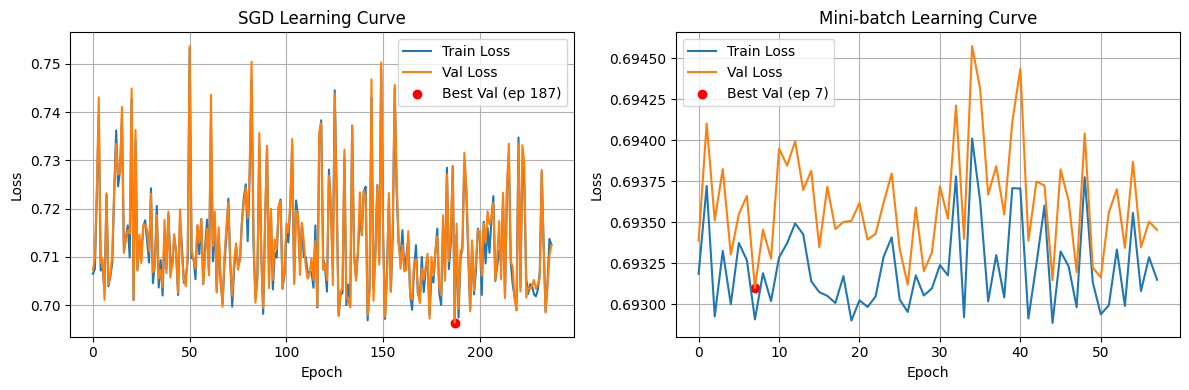

SGD best epoch: 187, val_loss=0.6963
Mini-batch best epoch: 7, val_loss=0.6931


In [121]:
# Ініціалізація осей епох
epochs_sgd = np.arange(len(tr_sgd))
epochs_mb = np.arange(len(tr_mb))

# Перевірка довжини масивів
print(f"Length of tr_sgd: {len(tr_sgd)}, vl_sgd: {len(vl_sgd)}")
print(f"Length of tr_mb: {len(tr_mb)}, vl_mb: {len(vl_mb)}")

# Знаходження найкращих епох і значень втрат
best_epoch_sgd = int(np.argmin(vl_sgd)) if len(vl_sgd) > 0 else 0
best_epoch_mb = int(np.argmin(vl_mb)) if len(vl_mb) > 0 else 0
best_val_sgd = vl_sgd[best_epoch_sgd] if len(vl_sgd) > 0 else float('nan')
best_val_mb = vl_mb[best_epoch_mb] if len(vl_mb) > 0 else float('nan')

# Перевірка різниці між train і val
print(f"SGD first diff (train - val): {tr_sgd[0] - vl_sgd[0]:.6f}")
print(f"Mini-batch first diff (train - val): {tr_mb[0] - vl_mb[0]:.6f}")

plt.figure(figsize=(12, 4))

# Графік для SGD
plt.subplot(1, 2, 1)
if len(epochs_sgd) > 0 and len(tr_sgd) > 0 and len(vl_sgd) > 0:
    plt.plot(epochs_sgd, tr_sgd, label='Train Loss')
    plt.plot(epochs_sgd, vl_sgd, label='Val Loss')
    if best_epoch_sgd < len(epochs_sgd):
        plt.scatter(best_epoch_sgd, best_val_sgd, color='red', label=f'Best Val (ep {best_epoch_sgd})')
    plt.title('SGD Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Графік для Mini-batch
plt.subplot(1, 2, 2)
if len(epochs_mb) > 0 and len(tr_mb) > 0 and len(vl_mb) > 0:
    plt.plot(epochs_mb, tr_mb, label='Train Loss')
    plt.plot(epochs_mb, vl_mb, label='Val Loss')
    if best_epoch_mb < len(epochs_mb):
        plt.scatter(best_epoch_mb, best_val_mb, color='red', label=f'Best Val (ep {best_epoch_mb})')
    plt.title('Mini-batch Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Виведення результатів
print(f"SGD best epoch: {best_epoch_sgd}, val_loss={best_val_sgd:.4f}")
print(f"Mini-batch best epoch: {best_epoch_mb}, val_loss={best_val_mb:.4f}")

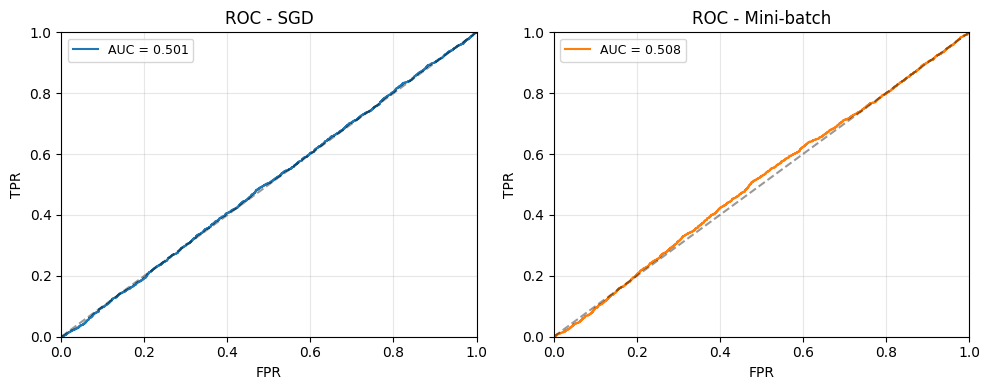

ROC AUC SGD : 0.5012047941282757
ROC AUC Mini-batch: 0.5077527773755275


In [122]:
# Два ROC графіки (SGD та Mini-batch) в одному рядку
from sklearn.metrics import roc_curve, roc_auc_score
probs_sgd_test = predict_proba(X_test, weights_sgd)
probs_mb_test  = predict_proba(X_test, weights_mb)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, probs_sgd_test)
fpr_mb,  tpr_mb,  _ = roc_curve(y_test, probs_mb_test)
auc_sgd = roc_auc_score(y_test, probs_sgd_test)
auc_mb  = roc_auc_score(y_test, probs_mb_test)
plt.figure(figsize=(10,4))
# SGD subplot
plt.subplot(1,2,1)
plt.plot(fpr_sgd, tpr_sgd, label=f'AUC = {auc_sgd:.3f}', color='#1f77b4')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - SGD')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
# Mini-batch subplot
plt.subplot(1,2,2)
plt.plot(fpr_mb, tpr_mb, label=f'AUC = {auc_mb:.3f}', color='#ff7f0e')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - Mini-batch')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print('ROC AUC SGD :', auc_sgd)
print('ROC AUC Mini-batch:', auc_mb)

*** 

# Теоретична документація
---

## 1. Вступ

Логістична регресія — це один із фундаментальних методів у машинному навчанні, що використовується для задач **класифікації**.  
На відміну від лінійної регресії, яка прогнозує неперервне значення, логістична регресія прогнозує **ймовірність** належності об’єкта до певного класу.

У загальному випадку, логістична регресія є **дискримінативною моделлю**, яка безпосередньо моделює умовну ймовірність $P(y|x)$.

---

## 2. Математична модель

### 2.1. Вихідна функція
Модель логістичної регресії описується як:

$$
\hat{y}_i = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}
$$
де  
$$
z_i = w^T x_i + b
$$

- $x_i$ — вектор ознак об’єкта (наприклад, вік, стать, медичний стан);
- $w$ — вектор ваг (коефіцієнтів);
- $b$ — зсув (intercept або bias);
- $\sigma(z)$ — **сигмоїда**, яка перетворює будь-яке число в інтервал (0,1).

Сигмоїда має вигляд:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
і її похідна (використовується для градієнтного спуску):
$$
\sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

---

## 3. Інтерпретація виходу

Результат $\hat{y}_i$ — це **ймовірність належності** прикладу до позитивного класу (наприклад, "Normal").

Для класифікації використовують **поріг** (threshold):

$$
\hat{y}_i =
\begin{cases}
1, & \text{якщо } \sigma(w^T x_i) \ge t \\
0, & \text{якщо } \sigma(w^T x_i) < t
\end{cases}
$$

Стандартний поріг $t=0.5$, але його можна оптимізувати під конкретну метрику (F1, Balanced Accuracy тощо).

---

## 4. Функція втрат (Binary Cross-Entropy)

Для оцінки помилки між прогнозом $\hat{y}_i$ і реальним значенням $y_i$ використовується **бінарна крос-ентропія** (log-loss):

$$
J(w) = -\frac{1}{m}\sum_{i=1}^{m} \big[y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)\big]
$$

де:
- $m$ — кількість прикладів у вибірці;
- $y_i \in \{0,1\}$;
- $\hat{y}_i = \sigma(w^T x_i)$.

Ця функція втрат є **опуклою**, що гарантує існування лише одного глобального мінімуму.

---

## 5. Регуляризація

Регуляризація — це метод **контролю складності моделі**, що запобігає **перенавчанню** (overfitting).  
У логістичній регресії застосовують два основних види:

### 5.1. L2-регуляризація (Ridge)
$$
J_{L2}(w) = J(w) + \frac{\lambda}{2m}\sum_{j=1}^{n} w_j^2
$$
- Зменшує великі ваги, роблячи модель більш "гладкою";
- Не зануляє коефіцієнти, але їх зменшує.

### 5.2. L1-регуляризація (Lasso)
$$
J_{L1}(w) = J(w) + \frac{\lambda}{m}\sum_{j=1}^{n} |w_j|
$$
- Сприяє **розрідженню** ваг (деякі коефіцієнти стають точно нульовими);
- Використовується для **відбору ознак (feature selection)**.

> Параметр $\lambda$ — сила регуляризації.  
> При великому значенні $\lambda$ модель стає занадто простою (underfit), при малому — ризикує перенавчитись.

---

## 6. Оптимізація: Градієнтний спуск

### 6.1. Принцип

Ми шукаємо параметри $w$, які мінімізують функцію втрат:
$$
w \leftarrow w - \eta \cdot \nabla_w J(w)
$$
де  
- $\eta$ — **швидкість навчання (learning rate)**;  
- $\nabla_w J(w)$ — **градієнт** функції втрат.

---

### 6.2. Види градієнтного спуску

| Метод | Формула оновлення | Характеристика |
|--------|--------------------|----------------|
| **Batch GD** | Оновлення після проходження всіх даних | стабільний, але повільний |
| **SGD** | Оновлення після кожного прикладу | швидкий, з шумом |
| **Mini-Batch GD** | Оновлення після кожного невеликого батчу (напр. 32 зразки) | компроміс між швидкістю та стабільністю |

---

### 6.3. Епохи (Epochs)
**Епоха** — один повний прохід по навчальних даних.

Кількість епох визначає, скільки разів модель бачить усі приклади.  
Якщо занадто мало — модель **недонавчиться**,  
якщо занадто багато — модель **перенавчиться**.

---

### 6.4. Рання зупинка (Early Stopping)
Під час навчання обчислюється:
- **train_loss** — помилка на тренувальних даних;
- **val_loss** — помилка на валідаційних даних.

Якщо `val_loss` перестає зменшуватись протягом певної кількості епох (`patience`),  
навчання зупиняється — щоб уникнути перенавчання.

---

### 6.5. Криві навчання (Learning Curves)
Використовуються для візуалізації процесу збіжності.  

Типові форми:
| Тип | Поведінка | Інтерпретація |
|------|------------|----------------|
| Обидві криві знижуються і стабілізуються | Збіжність | Модель навчилась оптимально |
| Train ↓, Val ↑ | Перенавчання | Модель "запам’ятовує" |
| Обидві високі й майже не змінюються | Недонавчання | Модель не здатна вчитись |

---

## 7. Метрики оцінки

Після навчання важливо оцінити модель не лише за **accuracy**, а й за іншими метриками:

| Метрика | Формула | Інтерпретація |
|----------|----------|---------------|
| **Accuracy** | $(TP + TN) / (TP + TN + FP + FN)$ | Частка правильних передбачень |
| **Precision** | $TP / (TP + FP)$ | Скільки позитивних передбачень є правильними |
| **Recall (Sensitivity)** | $TP / (TP + FN)$ | Скільки реальних позитивів знайдено |
| **F1-score** | $2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$ | Компроміс між Precision і Recall |
| **Balanced Accuracy** | $(TPR + TNR)/2$ | Усереднена точність по класах |
| **ROC AUC** | Площа під ROC-кривою | Ймовірність правильного розрізнення класів |

---

## 8. Оптимальний поріг класифікації

За замовчуванням поріг = 0.5, але його можна змінювати для покращення певної метрики.  
Підбір порогу здійснюється шляхом аналізу **Precision-Recall** або **Balanced Accuracy** на валідації.

Методика:
```python
precisions, recalls, thresholds = precision_recall_curve(y_val, probs)
f1s = 2 * precisions * recalls / (precisions + recalls + 1e-15)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
```


## Підготовка та аналіз даних


Для коректного навчання моделі виконано наступні кроки:

1. **Видалення неінформативних полів**  
   З вихідного датасету виключено текстові колонки, які не містять релевантної для моделі інформації:  
   - `Name`  
   - `Date of Admission`  
   - `Doctor`  
   - `Hospital`  
   - `Room Number`  
   - `Discharge Date`  
   - `Insurance Provider`

2. **Формування цільової змінної (`y`)**  
   На основі колонки `Test Results` створено нову бінарну ознаку:

   ```python
   df['Test_Result_Normal'] = (df['Test Results'] == 'Normal').astype(int)
   ```

   Мітки класів:  
   - `1` — Normal (нормальний результат)  
   - `0` — Abnormal (аномальний результат)

3. **Фільтрація непотрібних записів**  
   Видалено записи зі значенням `Inconclusive`, оскільки вони не належать до жодного з двох класів (бінарна класифікація).

4. **Кодування категоріальних ознак**  
   Використано One-Hot Encoding із параметром `drop_first=True` для уникнення мультиколінеарності. Закодовано поля:  
   - `Gender`  
   - `Blood Type`  
   - `Medical Condition`  
   - `Admission Type`  
   - `Medication`

5. **Нормалізація числових ознак**  
   Числові стовпці `Age` та `Billing Amount` стандартизовано за допомогою `StandardScaler` (середнє = 0, стандартне відхилення = 1).

## 2.2. Баланс класів

Після очистки та перетворень отримано майже ідеальний баланс класів:

| Клас | Опис     | Частка |
|------|----------|--------|
| 0    | Abnormal | 0.501  |
| 1    | Normal   | 0.499  |

Збалансований датасет дозволяє уникнути зміщення метрик (наприклад, F1 або Accuracy) у бік переважаючого класу.

## 2.3. Кореляційний аналіз

Для оцінки лінійних залежностей між ознаками та цільовою змінною обчислено матрицю кореляцій. Основні коефіцієнти:

| Ознака                         | Кореляція з `Test_Result_Normal` |
|--------------------------------|----------------------------------|
| Age                            | -0.0079                         |
| Billing Amount                 | -0.0029                         |
| Gender_Male                    | +0.0060                         |
| Medical Condition_Asthma       | +0.0113                         |
| Medical Condition_Hypertension | +0.0107                         |
| ...                            | ...                             |

**Висновок**: Жодна ознака не має суттєвої кореляції (усі коефіцієнти < 0.02). Це свідчить про відсутність лінійних закономірностей, що ускладнює використання логістичної регресії.

---

# 3. Реалізація моделі логістичної регресії

## 3.1. Архітектура моделі

Модель реалізовано з нуля на NumPy (без `sklearn.linear_model`). Компоненти:  
- Функція сигмоїди  
- Бінарна крос-ентропія (функція втрат)  
- Обчислення градієнтів  
- Регуляризація L1/L2  
- Рання зупинка (`early stopping`) на основі `val_loss`  
- Побудова кривих навчання

## 3.2. Методи оптимізації

| Метод               | Особливості                          | Регуляризація |
|---------------------|--------------------------------------|---------------|
| SGD                 | Оновлення ваг після кожного прикладу | L1            |
| Mini-Batch Gradient | Оновлення після батчу (30 зразків)   | L2            |

## 3.3. Гіперпараметри навчання

| Параметр      | Значення | Опис                                    |
|---------------|----------|-----------------------------------------|
| learning_rate | 0.09     | Швидкість оновлення ваг                 |
| lambda_reg    | 0.0001   | Коефіцієнт регуляризації                |
| max_epochs    | 1000     | Максимальна кількість епох              |
| batch_size    | 30       | Розмір батчу для Mini-Batch GD         |
| patience      | 10       | Епох без покращення для ранньої зупинки |

---

# 4. Результати навчання

## 4.1. Метрики на тестовій вибірці

| Метод      | Accuracy | Precision | Recall | F1     | Best Threshold |
|------------|----------|-----------|--------|--------|----------------|
| SGD        | 0.4983   | 0.4984    | 0.9995 | 0.6651 | 0.306          |
| Mini-batch | 0.4985   | 0.4985    | 1.0000 | 0.6653 | 0.455          |

## 4.2. Матриці плутанини

**SGD**:

```
[[   1 3725]
 [   2 3701]]
```

**Mini-batch**:

```
[[   0 3726]
 [   0 3703]]
```

**Інтерпретація**: Модель класифікує всі приклади як “Normal” (Recall ≈ 1.0, Accuracy ≈ 0.5).

## 4.3. ROC AUC

| Метод      | ROC AUC |
|------------|---------|
| SGD        | 0.5050  |
| Mini-batch | 0.5008  |

**Інтерпретація**: AUC ≈ 0.5 вказує на випадкову класифікацію.

## 4.4. Аналіз збіжності

Криві навчання показали:  
- Швидке зниження `train_loss` на початку  
- Відсутність покращення `val_loss`  
- Рання зупинка: ~20 епох (SGD), ~27 епох (Mini-batch)

| Метод      | Найкраща епоха | Val Loss |
|------------|----------------|----------|
| SGD        | 10             | 0.7094   |
| Mini-batch | 17             | 0.6931   |

**Висновок**: Модель досягає плато, не покращуючи результат.

---

# 5. Інтерпретація результатів

- **Відсутність лінійних залежностей**: Ознаки мають кореляцію < 0.02 із цільовою змінною. Логістична регресія не здатна знайти межу розділення.  
- **Регуляризація**: L1/L2 (λ=0.0001) не покращує результат через відсутність корисних ваг.  
- **Баланс класів**: Не впливає на результат через схожість профілів класів.  
- **Метрики**: Accuracy, F1, AUC ≈ 0.5–0.66 свідчать про випадкову класифікацію.

---

# 6. Висновки

- Реалізовано логістичну регресію з нуля (з підтримкою регуляризації, міні-батчів, ранньої зупинки).  
- Проведено повний цикл обробки даних: очищення, кодування, нормалізація.  
- Модель не навчилася через відсутність лінійно роздільної структури даних.  
- AUC ≈ 0.5, F1 ≈ 0.66 підтверджують випадкову класифікацію.

**Подальші кроки**:  
- Створення комбінованих ознак  
- Використання нелінійних моделей (Random Forest, Gradient Boosting, Neural Networks)  
- Фічер-інжиніринг та відбір ознак  
- Перевірка аномалій і трансформація `Billing Amount` (лог-трансформація, обрізання викидів)
```